In [12]:
print("Hello, World")

Hello, World


In [13]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import MobileNetV2, ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd

In [ ]:
class TomatoDiseaseClassifier:
    def __init__(self, data_dir="../data/tomato", model_type="mobilenet", img_size=224):
        """
        Initialize the Tomato Disease Classifier.
        
        Args:
            data_dir: Directory containing train, valid, and test folders
            model_type: Type of base model to use ('mobilenet' or 'resnet')
            img_size: Size to resize the images to
        """
        self.data_dir = data_dir
        self.model_type = model_type
        self.img_size = img_size
        self.model = None
        self.history = None
        
        # Get disease classes
        self.classes = sorted([d for d in os.listdir(os.path.join(data_dir, "train")) 
                         if os.path.isdir(os.path.join(data_dir, "train", d))])
        self.num_classes = len(self.classes)
        
        print(f"Found {self.num_classes} classes: {self.classes}")
        
        self.setup_data_generators()
    
    def setup_data_generators(self):
        """Set up data generators for training, validation and testing"""
        #data augmentation
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )
        
        valid_datagen = ImageDataGenerator(rescale=1./255)
        test_datagen = ImageDataGenerator(rescale=1./255)
        
        self.train_generator = train_datagen.flow_from_directory(
            os.path.join(self.data_dir, 'train'),
            target_size=(self.img_size, self.img_size),
            batch_size=32,
            class_mode='categorical',
            shuffle=True
        )
        
        self.valid_generator = valid_datagen.flow_from_directory(
            os.path.join(self.data_dir, 'valid'),
            target_size=(self.img_size, self.img_size),
            batch_size=32,
            class_mode='categorical',
            shuffle=False
        )
        
        self.test_generator = test_datagen.flow_from_directory(
            os.path.join(self.data_dir, 'test'),
            target_size=(self.img_size, self.img_size),
            batch_size=32,
            class_mode='categorical',
            shuffle=False
        )
        
        self.class_indices = self.train_generator.class_indices
        self.indices_to_classes = {v: k for k, v in self.class_indices.items()}
    
    def build_model(self):
        """Build the CNN model"""
        if self.model_type == 'mobilenet':
            #MobileNetV2 as primary base model (small/fast)
            base_model = MobileNetV2(
                weights='imagenet',
                include_top=False,
                input_shape=(self.img_size, self.img_size, 3)
            )
        elif self.model_type == 'resnet':
            #ResNet50 as secondary base model
            base_model = ResNet50(
                weights='imagenet',
                include_top=False,
                input_shape=(self.img_size, self.img_size, 3)
            )
        else:
            raise ValueError("model_type must be 'mobilenet' or 'resnet'")
        
        base_model.trainable = False #freeze base layer models
        
        #CNN Architecture (sequential)
        model = models.Sequential([
            base_model,
            layers.GlobalAveragePooling2D(),
            layers.BatchNormalization(),
            layers.Dense(256, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(self.num_classes, activation='softmax')
        ])
        
        #compile CNN model with HYPERPARAMETERS
        model.compile(
            optimizer=optimizers.Adam(learning_rate=0.001),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
        self.model = model
        print(model.summary())
        return model
    
    def train(self, epochs=20, fine_tune=True):
        """
        Train the model.
        
        Args:
            epochs: Number of epochs for initial training
            fine_tune: Whether to unfreeze and fine-tune the model
        """
        if self.model is None:
            self.build_model()
        
        checkpoint_path = os.path.join('models', 'tomato_model_checkpoint.h5')
        os.makedirs('models', exist_ok=True)
        
        callbacks = [
            ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_accuracy'),
            EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True),
            ReduceLROnPlateau(factor=0.2, patience=3, min_lr=1e-6)
        ]
        
        print("Training with frozen base model...")
        history = self.model.fit(
            self.train_generator,
            validation_data=self.valid_generator,
            epochs=epochs,
            callbacks=callbacks
        )
        
        #fine-tuning: unfreeze some layers of the base model
        if fine_tune and self.model_type == 'mobilenet':
            print("Fine-tuning the model...")
            #unfreeze the top layers of the base model
            base_model = self.model.layers[0]
            base_model.trainable = True
            
            #freeze all the layers except last 4 blocks
            for layer in base_model.layers[:-20]:
                layer.trainable = False
            
            #recompile the model with a lower learning rate
            self.model.compile(
                optimizer=optimizers.Adam(learning_rate=0.0001),
                loss='categorical_crossentropy',
                metrics=['accuracy']
            )
            fine_tune_history = self.model.fit(
                self.train_generator,
                validation_data=self.valid_generator,
                epochs=10,
                callbacks=callbacks
            )
            
            for key in fine_tune_history.history:
                history.history[key].extend(fine_tune_history.history[key])
        
        self.history = history
        return history
    
    def evaluate(self):
        test_loss, test_acc = self.model.evaluate(self.test_generator)
        print(f"Test accuracy: {test_acc:.4f}")
        print(f"Test loss: {test_loss:.4f}")
        
        predictions = self.model.predict(self.test_generator)
        y_pred = np.argmax(predictions, axis=1)
        
        y_true = self.test_generator.classes
        report = classification_report(
            y_true, 
            y_pred, 
            target_names=self.classes,
            output_dict=True
        )
        
        #CLASSIFICATION REPORT
        report_df = pd.DataFrame(report).transpose()
        print("\nClassification Report:")
        print(report_df)
        
        #CONFUSION MATRIX
        plt.figure(figsize=(12, 10))
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=self.classes, yticklabels=self.classes)
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.savefig('models/confusion_matrix_tomato.png')
        self.plot_training_history()
        
        return test_acc, report
    
    def plot_training_history(self):
        """Plot training and validation accuracy/loss"""
        if self.history is None:
            print("No training history available.")
            return
        
        plt.figure(figsize=(12, 5))
        
        #CNN Accuracy
        plt.subplot(1, 2, 1)
        plt.plot(self.history.history['accuracy'])
        plt.plot(self.history.history['val_accuracy'])
        plt.title('Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='lower right')
        
        #CNN Loss
        plt.subplot(1, 2, 2)
        plt.plot(self.history.history['loss'])
        plt.plot(self.history.history['val_loss'])
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper right')
        
        plt.tight_layout()
        plt.savefig('models/training_history_tomato.png')
    
    def save_model(self, filename='tomato_disease_classi fier.h5'):
        """Save the model to disk"""
        if self.model is not None:
            model_path = os.path.join('models', filename)
            self.model.save(model_path)
            print(f"Model saved to {model_path}")
            
            #save the class indices mapping for later
            import json
            indices_path = os.path.join('models', 'tomato_class_indices.json')
            with open(indices_path, 'w') as f:
                json.dump(self.class_indices, f)
            print(f"Class indices saved to {indices_path}")
    
    def predict_image(self, image_path):
        """
        Predict the disease class for a single image.
        
        Args:
            image_path: Path to the image file
        
        Returns:
            Dictionary with prediction probabilities and top predictions
        """
        from tensorflow.keras.preprocessing import image
        
        img = image.load_img(image_path, target_size=(self.img_size, self.img_size))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = img_array / 255.0  #rescale (from earlier 224 augmentation)
        
        #CNN Prediction
        predictions = self.model.predict(img_array)[0]
        
        top_indices = predictions.argsort()[-4:][::-1]  #get top 4 (probability) predictions
        top_predictions = [
            (self.indices_to_classes[i], float(predictions[i]))
            for i in top_indices
        ]
        
        result = {
            "top_predictions": top_predictions,
            "all_probabilities": {self.indices_to_classes[i]: float(prob) 
                                 for i, prob in enumerate(predictions)}
        }
        
        return result

In [15]:
classifier = TomatoDiseaseClassifier(model_type='mobilenet')
classifier.build_model()

Found 11 classes: ['Bacterial_spot', 'Early_blight', 'Late_blight', 'Leaf_Mold', 'Septoria_leaf_spot', 'Spider_mites Two-spotted_spider_mite', 'Target_Spot', 'Tomato_Yellow_Leaf_Curl_Virus', 'Tomato_mosaic_virus', 'healthy', 'powdery_mildew']
Found 24577 images belonging to 11 classes.
Found 6510 images belonging to 11 classes.
Found 1447 images belonging to 11 classes.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,625,355 (10.01 MB)

 Trainable params: 364,811 (1.39 MB)

 Non-trainable params: 2,260,544 (8.62 MB)

None


<Sequential name=sequential_1, built=True>

In [16]:
classifier.train(epochs=15, fine_tune=True)

Training with frozen base model...
Epoch 1/15
769/769 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.4927 - loss: 1.5695

769/769 ━━━━━━━━━━━━━━━━━━━━ 172s 222ms/step - accuracy: 0.4928 - loss: 1.5690 - val_accuracy: 0.7771 - val_loss: 0.6775 - learning_rate: 0.0010
Epoch 2/15
769/769 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.6891 - loss: 0.8952

769/769 ━━━━━━━━━━━━━━━━━━━━ 167s 218ms/step - accuracy: 0.6891 - loss: 0.8952 - val_accuracy: 0.8098 - val_loss: 0.5609 - learning_rate: 0.0010
Epoch 3/15
769/769 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.7366 - loss: 0.7762

769/769 ━━━━━━━━━━━━━━━━━━━━ 168s 218ms/step - accuracy: 0.7366 - loss: 0.7761 - val_accuracy: 0.8154 - val_loss: 0.5490 - learning_rate: 0.0010
Epoch 4/15
769/769 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.7594 - loss: 0.7052

769/769 ━━━━━━━━━━━━━━━━━━━━ 170s 220ms/step - accuracy: 0.7594 - loss: 0.7052 - val_accuracy: 0.8273 - val_loss: 0.5127 - learning_rate: 0.0010
Epoch 5/15
769/769 ━━━━━━━━━━━━━━━━━━━━ 167s 217ms/step - accuracy: 0.7682 - loss: 0.6826 - val_accuracy: 0.8220 - val_loss: 0.5122 - learning_rate: 0.0010
Epoch 6/15
769/769 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.7806 - loss: 0.6433

769/769 ━━━━━━━━━━━━━━━━━━━━ 168s 219ms/step - accuracy: 0.7806 - loss: 0.6433 - val_accuracy: 0.8318 - val_loss: 0.4741 - learning_rate: 0.0010
Epoch 7/15
769/769 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.7900 - loss: 0.6199

769/769 ━━━━━━━━━━━━━━━━━━━━ 170s 221ms/step - accuracy: 0.7900 - loss: 0.6199 - val_accuracy: 0.8484 - val_loss: 0.4510 - learning_rate: 0.0010
Epoch 8/15
769/769 ━━━━━━━━━━━━━━━━━━━━ 169s 219ms/step - accuracy: 0.7913 - loss: 0.6139 - val_accuracy: 0.8461 - val_loss: 0.4414 - learning_rate: 0.0010
Epoch 9/15
769/769 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.8032 - loss: 0.5903

769/769 ━━━━━━━━━━━━━━━━━━━━ 168s 218ms/step - accuracy: 0.8032 - loss: 0.5903 - val_accuracy: 0.8501 - val_loss: 0.4426 - learning_rate: 0.0010
Epoch 10/15
769/769 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.8068 - loss: 0.5677

769/769 ━━━━━━━━━━━━━━━━━━━━ 170s 220ms/step - accuracy: 0.8068 - loss: 0.5677 - val_accuracy: 0.8556 - val_loss: 0.4198 - learning_rate: 0.0010
Epoch 11/15
769/769 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.8137 - loss: 0.5508

769/769 ━━━━━━━━━━━━━━━━━━━━ 169s 219ms/step - accuracy: 0.8137 - loss: 0.5507 - val_accuracy: 0.8624 - val_loss: 0.4081 - learning_rate: 0.0010
Epoch 12/15
769/769 ━━━━━━━━━━━━━━━━━━━━ 170s 220ms/step - accuracy: 0.8132 - loss: 0.5500 - val_accuracy: 0.8570 - val_loss: 0.4154 - learning_rate: 0.0010
Epoch 13/15
769/769 ━━━━━━━━━━━━━━━━━━━━ 166s 215ms/step - accuracy: 0.8184 - loss: 0.5339 - val_accuracy: 0.8512 - val_loss: 0.4199 - learning_rate: 0.0010
Epoch 14/15
769/769 ━━━━━━━━━━━━━━━━━━━━ 168s 219ms/step - accuracy: 0.8198 - loss: 0.5193 - val_accuracy: 0.8579 - val_loss: 0.4073 - learning_rate: 0.0010
Epoch 15/15
769/769 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.8236 - loss: 0.5083

769/769 ━━━━━━━━━━━━━━━━━━━━ 166s 215ms/step - accuracy: 0.8236 - loss: 0.5083 - val_accuracy: 0.8743 - val_loss: 0.3728 - learning_rate: 0.0010
Fine-tuning the model...
Epoch 1/10
769/769 ━━━━━━━━━━━━━━━━━━━━ 183s 236ms/step - accuracy: 0.7713 - loss: 0.7143 - val_accuracy: 0.7154 - val_loss: 1.4278 - learning_rate: 1.0000e-04
Epoch 2/10
769/769 ━━━━━━━━━━━━━━━━━━━━ 179s 232ms/step - accuracy: 0.8427 - loss: 0.4718 - val_accuracy: 0.8469 - val_loss: 0.5179 - learning_rate: 1.0000e-04
Epoch 3/10
769/769 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.8700 - loss: 0.3858

769/769 ━━━━━━━━━━━━━━━━━━━━ 181s 235ms/step - accuracy: 0.8700 - loss: 0.3858 - val_accuracy: 0.8760 - val_loss: 0.3931 - learning_rate: 1.0000e-04
Epoch 4/10
769/769 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.8872 - loss: 0.3440

769/769 ━━━━━━━━━━━━━━━━━━━━ 183s 238ms/step - accuracy: 0.8872 - loss: 0.3440 - val_accuracy: 0.8919 - val_loss: 0.3465 - learning_rate: 1.0000e-04
Epoch 5/10
769/769 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.9016 - loss: 0.2927

769/769 ━━━━━━━━━━━━━━━━━━━━ 181s 236ms/step - accuracy: 0.9016 - loss: 0.2927 - val_accuracy: 0.9201 - val_loss: 0.2552 - learning_rate: 1.0000e-04
Epoch 6/10
769/769 ━━━━━━━━━━━━━━━━━━━━ 181s 235ms/step - accuracy: 0.9023 - loss: 0.2942 - val_accuracy: 0.8960 - val_loss: 0.3271 - learning_rate: 1.0000e-04
Epoch 7/10
769/769 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.9178 - loss: 0.2479

769/769 ━━━━━━━━━━━━━━━━━━━━ 180s 234ms/step - accuracy: 0.9178 - loss: 0.2479 - val_accuracy: 0.9215 - val_loss: 0.2435 - learning_rate: 1.0000e-04
Epoch 8/10
769/769 ━━━━━━━━━━━━━━━━━━━━ 184s 239ms/step - accuracy: 0.9185 - loss: 0.2475 - val_accuracy: 0.8535 - val_loss: 0.4889 - learning_rate: 1.0000e-04
Epoch 9/10
769/769 ━━━━━━━━━━━━━━━━━━━━ 184s 239ms/step - accuracy: 0.9259 - loss: 0.2254 - val_accuracy: 0.9214 - val_loss: 0.2481 - learning_rate: 1.0000e-04
Epoch 10/10
769/769 ━━━━━━━━━━━━━━━━━━━━ 180s 234ms/step - accuracy: 0.9334 - loss: 0.2020 - val_accuracy: 0.8808 - val_loss: 0.4602 - learning_rate: 1.0000e-04


/Users/john/programming/cnn/41079-research-project/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - accuracy: 0.8283 - loss: 0.5055
Test accuracy: 0.8611
Test loss: 0.4446
46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 156ms/step

Classification Report:
                                      precision    recall  f1-score  \
Bacterial_spot                         0.840000  0.801527  0.820312   
Early_blight                           0.593750  0.558824  0.575758   
Late_blight                            0.909091  0.800000  0.851064   
Leaf_Mold                              0.892308  0.805556  0.846715   
Septoria_leaf_spot                     0.635922  0.935714  0.757225   
Spider_mites Two-spotted_spider_mite   0.988571  0.871537  0.926372   
Target_Spot                            0.910891  0.888889  0.899756   
Tomato_Yellow_Leaf_Curl_Virus          1.000000  0.714286  0.833333   
Tomato_mosaic_virus                    0.829787  0.795918  0.812500   
healthy                                0.767857  0.921429  0.837662   
powdery_mildew                         

(0.8610919117927551,
 {'Bacterial_spot': {'precision': 0.84,
   'recall': 0.8015267175572519,
   'f1-score': 0.8203125,
   'support': 131.0},
  'Early_blight': {'precision': 0.59375,
   'recall': 0.5588235294117647,
   'f1-score': 0.5757575757575758,
   'support': 34.0},
  'Late_blight': {'precision': 0.9090909090909091,
   'recall': 0.8,
   'f1-score': 0.851063829787234,
   'support': 150.0},
  'Leaf_Mold': {'precision': 0.8923076923076924,
   'recall': 0.8055555555555556,
   'f1-score': 0.8467153284671532,
   'support': 72.0},
  'Septoria_leaf_spot': {'precision': 0.6359223300970874,
   'recall': 0.9357142857142857,
   'f1-score': 0.7572254335260116,
   'support': 140.0},
  'Spider_mites Two-spotted_spider_mite': {'precision': 0.9885714285714285,
   'recall': 0.871536523929471,
   'f1-score': 0.9263721552878179,
   'support': 397.0},
  'Target_Spot': {'precision': 0.9108910891089109,
   'recall': 0.8888888888888888,
   'f1-score': 0.8997555012224939,
   'support': 207.0},
  'Tomato_Y

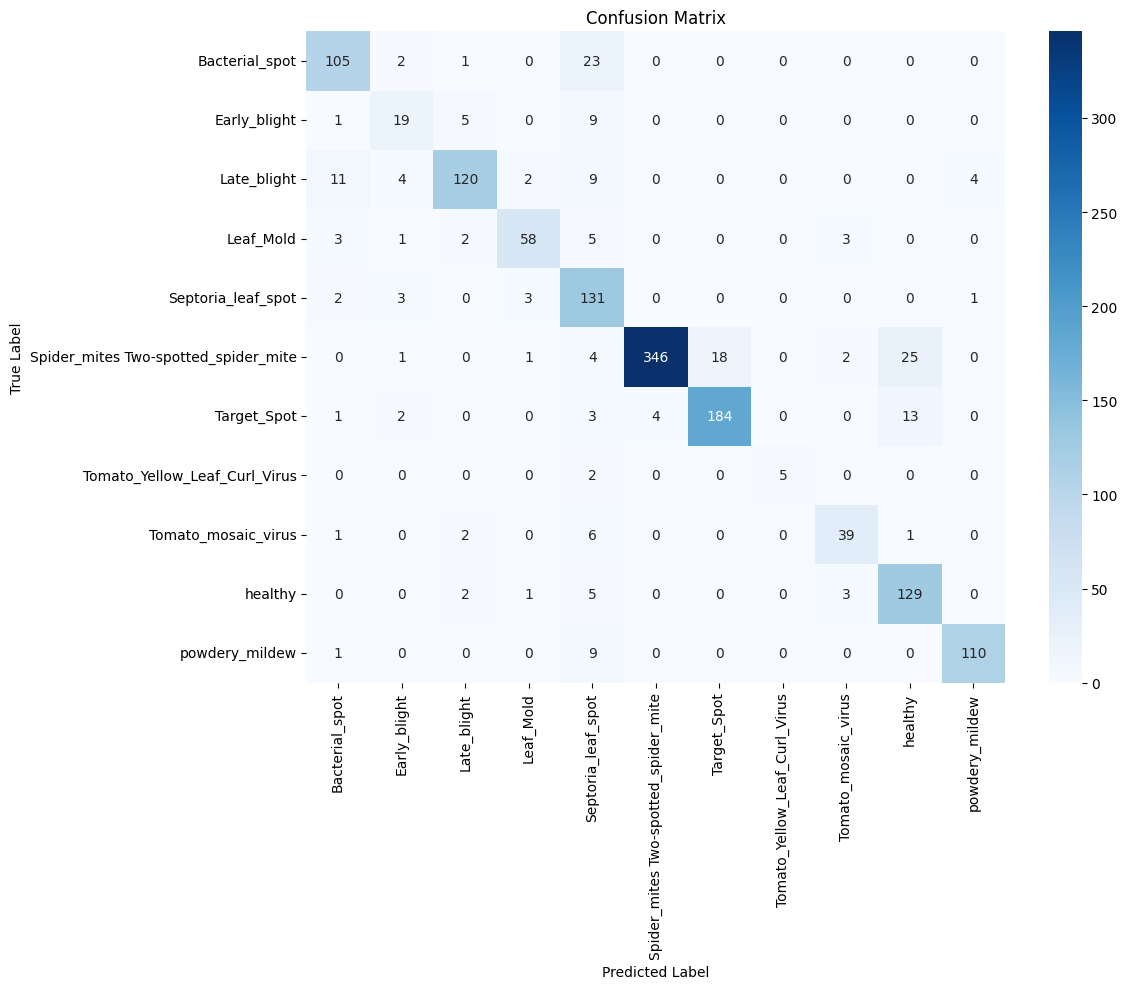

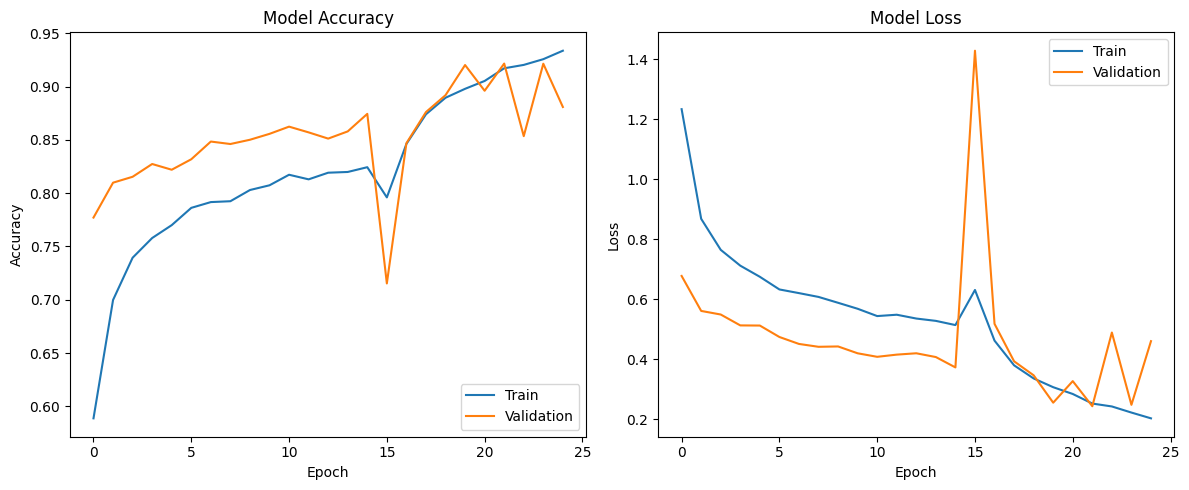

In [17]:
classifier.evaluate()

In [19]:
classifier.save_model()

Model saved to models/tomato_disease_classifier.h5
Class indices saved to models/tomato_class_indices.json


#### Sample Prediction

In [20]:
import glob
import random
#sample prediction from model
test_images = glob.glob(os.path.join('data/tomato/test/*/*.jpg'))
if test_images:
    test_image = random.choice(test_images)
    print(f"\nPredicting disease for test image: {test_image}")
    
    result = classifier.predict_image(test_image)
    
    print("\nTop predictions:")
    for disease, probability in result["top_predictions"]:
        print(f"{disease}: {probability:.4f} ({probability*100:.2f}%)")